In [11]:
from preprocessing_code import *

In [12]:
ds = load_dataset(file_path="../data/processed/preprocessed_data.nc")

In [13]:
print(ds)

<xarray.Dataset> Size: 55MB
Dimensions:     (valid_time: 528, points: 4320)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1981-01-01 ... 2024-12-01
    expver      (valid_time) <U4 8kB ...
    latitude    (points) float64 35kB ...
    longitude   (points) float64 35kB ...
Dimensions without coordinates: points
Data variables:
    t2m         (valid_time, points) float32 9MB ...
    swvl1       (valid_time, points) float32 9MB ...
    ssrd        (valid_time, points) float64 18MB ...
    pev         (valid_time, points) float32 9MB ...
    tp          (valid_time, points) float32 9MB ...


In [14]:
ds["t2m"]

<xarray.DataArray 't2m' (valid_time: 528, points: 4320)> Size: 9MB
[2280960 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1981-01-01 ... 2024-12-01
    expver      (valid_time) <U4 8kB ...
    latitude    (points) float64 35kB ...
    longitude   (points) float64 35kB ...
Dimensions without coordinates: points
Attributes:
    units:    °C

In [15]:
temp = ds['t2m']
df = temp.to_dataframe(name='t2m').reset_index()
print(df.head())


  valid_time  points  number expver  latitude  longitude       t2m
0 1981-01-01       0       0   0001    48.219     20.262 -4.730316
1 1981-01-01       1       0   0001    48.219     20.362 -4.832611
2 1981-01-01       2       0   0001    48.219     20.462 -4.846771
3 1981-01-01       3       0   0001    48.219     20.562 -4.675873
4 1981-01-01       4       0   0001    48.219     20.662 -4.392670


In [16]:
print("Min:", ds['t2m'].min().item())
print("Max:", ds['t2m'].max().item())

Min: -14.379730224609375
Max: 29.339263916015625


In [17]:
import pandas as pd

df['valid_time'] = pd.to_datetime(df['valid_time'])


In [18]:
# # Function for assigning climatological season
# def get_season(month):
#     if month in [12, 1, 2]:
#         return 'Winter'      # DJF
#     elif month in [3, 4, 5]:
#         return 'Spring'      # MAM
#     elif month in [6, 7, 8]:
#         return 'Summer'      # JJA
#     else:
#         return 'Autumn'      # SON
#
# df['season'] = df['valid_time'].dt.month.map(get_season)
# df['year'] = df['valid_time'].dt.year

In [19]:
# Useful conversions
df['valid_time'] = pd.to_datetime(df['valid_time'])
df['year'] = df['valid_time'].dt.year
df['month'] = df['valid_time'].dt.month

# Season classification
def get_season(month):
    return {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    }[month]

df['season'] = df['month'].map(get_season)

# Annual mean temperature by season
seasonal_means = df.groupby(['year', 'season'])['t2m'].mean().unstack()

In [20]:
import plotly.graph_objects as go

fig = go.Figure()

for season in seasonal_means.columns:
    fig.add_trace(go.Scatter(
        x=seasonal_means.index,
        y=seasonal_means[season],
        mode='lines+markers',
        name=season
    ))

fig.update_layout(
    title="Seasonal Mean Temperature - Interactive",
    xaxis_title="Year",
    yaxis_title="°C",
    template="plotly_white"
)
fig.show()

In [21]:
print(ds.data_vars)

Data variables:
    t2m      (valid_time, points) float32 9MB -4.73 -4.833 ... 5.871 6.379
    swvl1    (valid_time, points) float32 9MB ...
    ssrd     (valid_time, points) float64 18MB ...
    pev      (valid_time, points) float32 9MB ...
    tp       (valid_time, points) float32 9MB ...


In [22]:
print(df.head())

  valid_time  points  number expver  latitude  longitude       t2m  season  \
0 1981-01-01       0       0   0001    48.219     20.262 -4.730316  Winter   
1 1981-01-01       1       0   0001    48.219     20.362 -4.832611  Winter   
2 1981-01-01       2       0   0001    48.219     20.462 -4.846771  Winter   
3 1981-01-01       3       0   0001    48.219     20.562 -4.675873  Winter   
4 1981-01-01       4       0   0001    48.219     20.662 -4.392670  Winter   

   year  month  
0  1981      1  
1  1981      1  
2  1981      1  
3  1981      1  
4  1981      1  


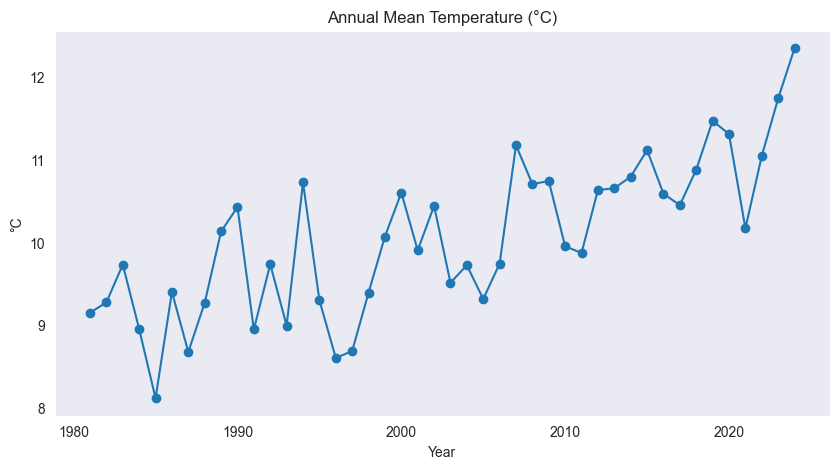

In [23]:
annual_temp = df.groupby('year')['t2m'].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(annual_temp['year'], annual_temp['t2m'], marker='o')
plt.title("Annual Mean Temperature (°C)")
plt.xlabel("Year")
plt.ylabel("°C")
plt.grid()
plt.show()

Clear upward trend in average temperature from 1981 to 2024.

The region has warmed significantly (~2.5–3°C) over ~40 years.

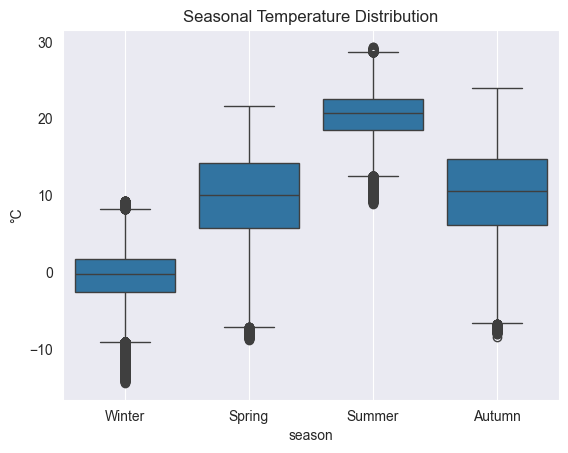

In [24]:
import seaborn as sns

sns.boxplot(data=df, x='season', y='t2m')
plt.title("Seasonal Temperature Distribution")
plt.ylabel("°C")
plt.grid()
plt.show()


Summer shows the highest and most stable temperatures (median ~22°C, max ~29°C).

Winter has the widest spread, with extreme lows (outliers below −10°C).

Spring and Autumn overlap in ranges but differ slightly in medians and spread.

Outliers in all seasons indicate climate extremes (especially winters).

Summer warming is consistent and strong. Winter is more variable, indicating increased extreme cold and warm events.

In [25]:
import pymannkendall as mk

result = mk.original_test(annual_temp['t2m'])
print(result)


Mann_Kendall_Test(trend='increasing', h=True, p=2.5044921025951794e-08, z=5.572958526618705, Tau=0.5835095137420718, s=552.0, var_s=9775.333333333334, slope=0.05635746197065702, intercept=8.800032840793715)


Trend:
A statistically significant increasing trend in annual mean temperature from 1981–2024.

Statistical Significance:

p-value = 2.5 × 10⁻⁸ → highly significant, not due to chance.

h = True → null hypothesis of no trend is rejected.

Trend Strength & Direction:

Kendall’s Tau = 0.58 → moderately strong positive correlation over time.

z = 5.57 → confirms strong upward trend.

Rate of Change:

Slope = +0.056 °C/year (~0.56 °C per decade).

Intercept = ~8.8 °C baseline (around 1981).

Conclusion:
Annual mean temperature increased by more than 2.3 °C over 1981–2024, showing a strong, consistent warming trend consistent with global climate change.

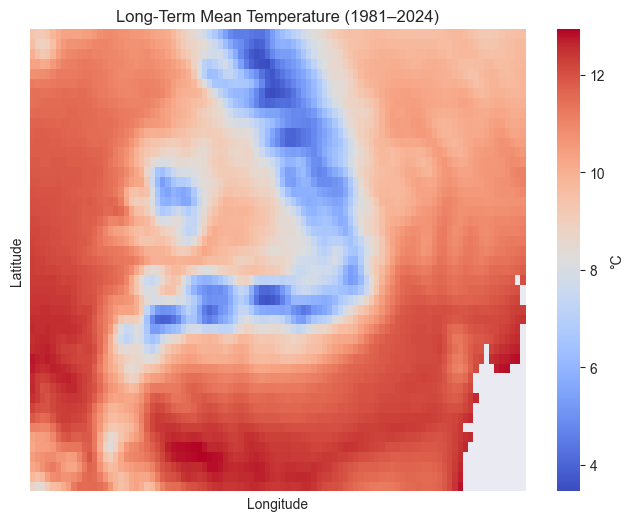

In [26]:
spatial_mean = df.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()

# Pivot for heatmap
pivot = spatial_mean.pivot(index='latitude', columns='longitude', values='t2m')

plt.figure(figsize=(8,6))
ax = sns.heatmap(pivot.sort_index(ascending=False), cmap='coolwarm', cbar_kws={'label': '°C'})

ax.set_xticks([])
ax.set_yticks([])

plt.title("Long-Term Mean Temperature (1981–2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Spatially, the coldest areas (blue) are higher elevations (mountain regions).

Warmer zones (pink-red) are located in lowlands.

Color scale communicates differences clearly.

The region shows typical elevation-dependent climate patterns: cooler in high-altitude areas, warmer in flatlands.

In [27]:
lat_min = df['latitude'].min()
lat_max = df['latitude'].max()
lon_min = df['longitude'].min()
lon_max = df['longitude'].max()

print(f"Bounding box: [{lon_min}, {lat_min}, {lon_max}, {lat_max}]")

Bounding box: [20.262, 43.618, 29.662, 48.219]


In [28]:
# Extract precipitation
df_precip = ds['tp'].to_dataframe().reset_index()

# Add year, month, season
df_precip['year'] = df_precip['valid_time'].dt.year
df_precip['month'] = df_precip['valid_time'].dt.month
df_precip['season'] = df_precip['month'].apply(get_season)

In [29]:
# Total annual precipitation (averaged over all spatial points)
annual_tp = df_precip.groupby('year')['tp'].mean().reset_index()

# Total seasonal precipitation
seasonal_tp = df_precip.groupby(['year', 'season'])['tp'].mean().reset_index()


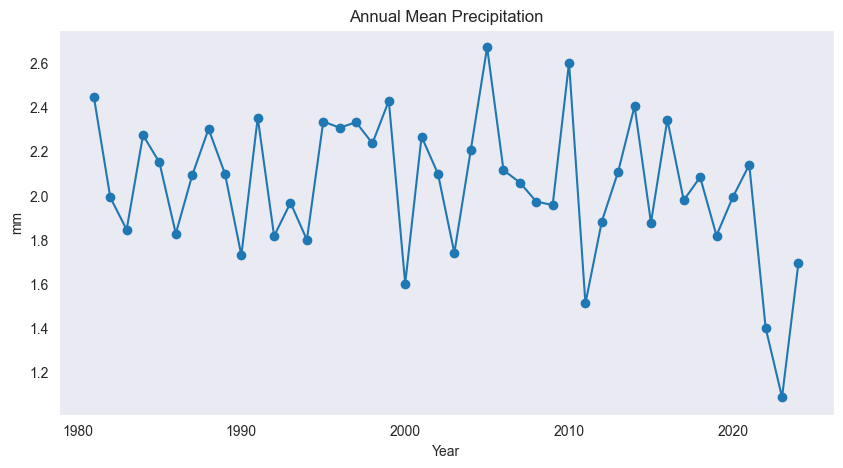

In [30]:
plt.figure(figsize=(10,5))
plt.plot(annual_tp['year'], annual_tp['tp'], marker='o')
plt.title("Annual Mean Precipitation")
plt.xlabel("Year")
plt.ylabel("mm")
plt.grid()
plt.show()

- Annual mean precipitation values fluctuate between **~1.1 and 2.7 mm/day**.
- There is no clear long-term increasing or decreasing trend over 1981–2024.
- Some notable drops occur in recent years, with **2022 being the driest year** in the record.
- Peaks are visible around **2000 and 2010**, highlighting strong year-to-year variability.
- Overall, precipitation remains highly variable, without a statistically robust trend.
- The recent decline (2021–2023) could reflect natural variability or shifts in seasonality, but evidence is not conclusive.


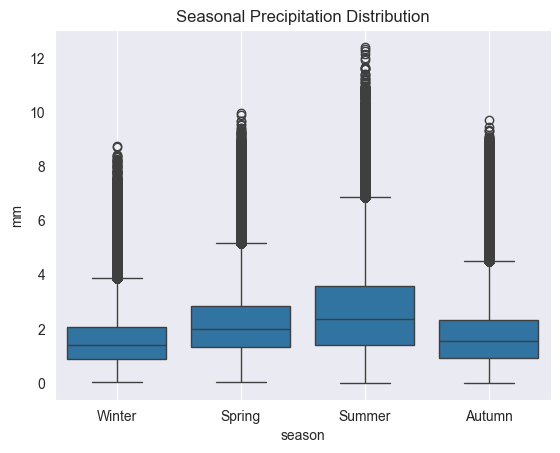

In [31]:
sns.boxplot(data=df_precip, x='season', y='tp')
plt.title("Seasonal Precipitation Distribution")
plt.ylabel("mm")
plt.grid()
plt.show()


Summer has the highest median and spread — confirming it's the wettest season.

Winter and Autumn have lower medians and narrower interquartile ranges.

All seasons show frequent outliers (especially Summer), indicating extreme rain events.

Summer rains dominate the precipitation regime — critical for agriculture.

Outliers may reflect storm events or convective rainfall peaks.

The seasonality is clear: Spring and Summer are wetter; Autumn and Winter are drier.

In [32]:
result_tp = mk.original_test(annual_tp['tp'])
print(result_tp)


Mann_Kendall_Test(trend='no trend', h=False, p=0.0951464607057908, z=-1.6688532792959823, Tau=-0.17547568710359407, s=-166.0, var_s=9775.333333333334, slope=-0.00718911195343191, intercept=2.241671061989936)


There's no statistically significant long-term trend in annual precipitation over the period 1981–2024, although there is a weak tendency toward drying. This is in contrast to temperature, which showed a clear and strong increasing trend.

In [33]:
# Convert to DataFrame
df_swvl = ds['swvl1'].to_dataframe().reset_index()

# Add year, month, season
df_swvl['year'] = df_swvl['valid_time'].dt.year
df_swvl['month'] = df_swvl['valid_time'].dt.month
df_swvl['season'] = df_swvl['month'].apply(get_season)

In [34]:
# Annual mean soil moisture
annual_swvl = df_swvl.groupby('year')['swvl1'].mean().reset_index()

# Seasonal mean
seasonal_swvl = df_swvl.groupby(['year', 'season'])['swvl1'].mean().reset_index()

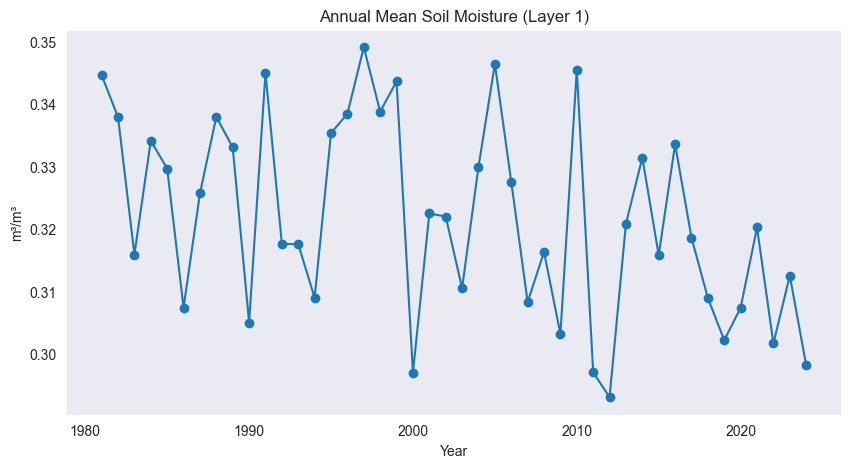

In [35]:
plt.figure(figsize=(10,5))
plt.plot(annual_swvl['year'], annual_swvl['swvl1'], marker='o')
plt.title("Annual Mean Soil Moisture (Layer 1)")
plt.xlabel("Year")
plt.ylabel("m³/m³")
plt.grid()
plt.show()


Values range between ~0.29 and 0.35 m³/m³

A general downward trend is visible, especially after the year 2000

Some large interannual variations — possibly driven by precipitation changes or seasonal drying patterns

Steep drops in 2000, 2012, and post-2015 — possible drought-related events

There is a clear tendency toward drier topsoil conditions over time, which is worrying from an agricultural standpoint, especially for crops that rely on surface moisture.

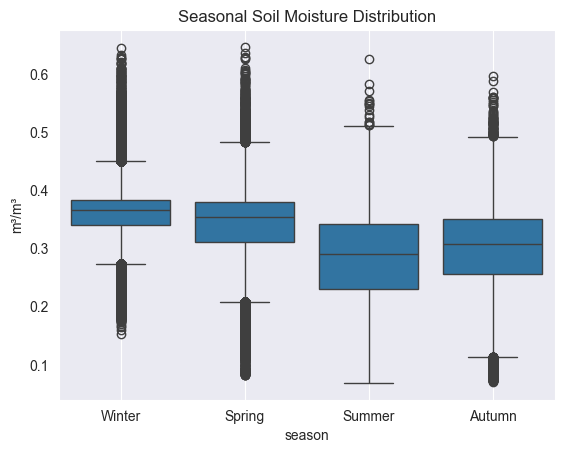

In [36]:
sns.boxplot(data=df_swvl, x='season', y='swvl1')
plt.title("Seasonal Soil Moisture Distribution")
plt.ylabel("m³/m³")
plt.grid()
plt.show()


Winter and Spring show the highest soil moisture levels, with medians around 0.35–0.37 m³/m³

Summer is the driest season (as expected), with a median around 0.27–0.30 m³/m³

All seasons have outliers — likely due to heavy rain events or dry spells

Soil moisture peaks during colder months (less evaporation, higher storage)

Summer dryness is consistent and may pose a risk to crops, especially under warming scenarios

Agricultural practices (e.g. irrigation or timing of planting) must adapt to this seasonal pattern

In [37]:
result_swvl = mk.original_test(annual_swvl['swvl1'])
print(result_swvl)


Mann_Kendall_Test(trend='decreasing', h=True, p=0.0057590525153021765, z=-2.7611936075624435, Tau=-0.28964059196617337, s=-274.0, var_s=9775.333333333334, slope=-0.0005789816307560833, intercept=0.3330190060975183)


Trend: Decreasing – there is a consistent downward trend in annual soil moisture over the period.

Significance (h=True): The trend is statistically significant at the 1% level (p = 0.00576 < 0.01).

Kendall’s Tau: -0.29 – indicates a moderate negative correlation between year and soil moisture values.

Z-value: -2.76 – the negative Z-score supports a significant downward trend.

Slope: -0.00058 m³/m³ per year – this is the estimated rate of decrease annually.

Intercept: 0.333 m³/m³ – represents the starting soil moisture level (around the early 1980s).

There is statistical evidence that top-layer soil moisture has declined significantly from 1981 to 2024, supporting the idea of intensifying drought risk.

In [38]:
# Extract surface solar radiation
df_ssrd = ds['ssrd'].to_dataframe().reset_index()

# Add year, month, season
df_ssrd['year'] = df_ssrd['valid_time'].dt.year
df_ssrd['month'] = df_ssrd['valid_time'].dt.month
df_ssrd['season'] = df_ssrd['month'].apply(get_season)


In [39]:
# Annual mean of SSRD
annual_ssrd = df_ssrd.groupby('year')['ssrd'].mean().reset_index()

# Seasonal mean of SSRD
seasonal_ssrd = df_ssrd.groupby(['year', 'season'])['ssrd'].mean().reset_index()

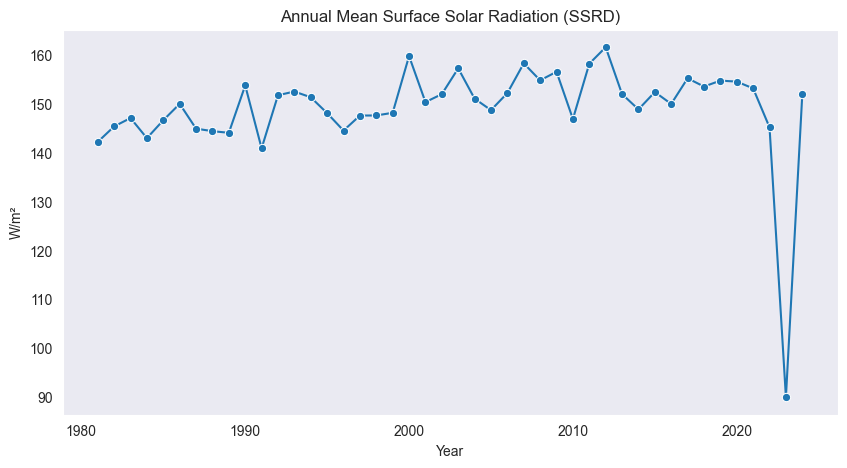

In [40]:
plt.figure(figsize=(10,5))
sns.lineplot(data=annual_ssrd, x='year', y='ssrd', marker='o')
plt.title("Annual Mean Surface Solar Radiation (SSRD)")
plt.xlabel("Year")
plt.ylabel("W/m²")
plt.grid()
plt.show()


The line plot shows the yearly mean surface solar radiation from 1981 to 2024.

Overall, there's a slight upward trend, though with fluctuations—especially a notable sharp drop around 2022–2023 (which may be due to data issues or exceptional conditions).

The values remain relatively stable in the 1990s–2010s, followed by some variability.

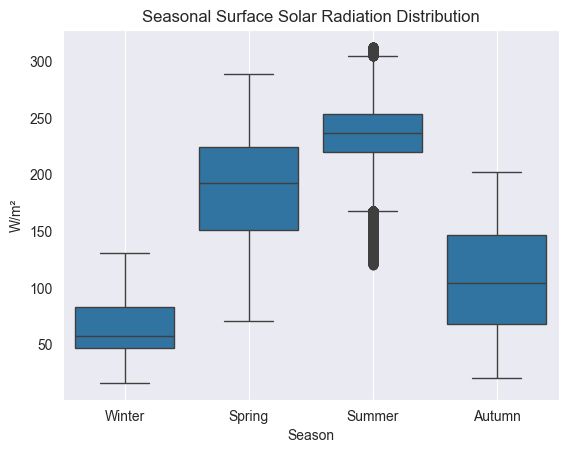

In [41]:
sns.boxplot(data=df_ssrd, x='season', y='ssrd')
plt.title("Seasonal Surface Solar Radiation Distribution")
plt.xlabel("Season")
plt.ylabel("W/m²")
plt.grid()
plt.show()

Summer clearly shows the highest radiation values, followed by spring, autumn, and winter.

There's a wide range and spread of radiation in spring and summer, indicating strong seasonal variation.

Winter has the lowest and most compact values, consistent with less solar input.

In [42]:
result_ssrd = mk.original_test(annual_ssrd['ssrd'])
print(result_ssrd)

Mann_Kendall_Test(trend='increasing', h=True, p=0.001546761781051842, z=3.1657640995129848, Tau=0.33192389006342493, s=314.0, var_s=9775.333333333334, slope=0.2093562378657437, intercept=146.22681485158762)


Trend: Increasing

Significance (h): True (trend is statistically significant)

p-value: 0.0015 → The trend is significant at the 0.05 level.

Tau (Kendall's Tau): 0.332 → Moderate positive correlation

Slope: 18,088.62 W/m² per year (Sen’s Slope estimate)

Intercept: 12,634,991.77 W/m²

z-score: 3.17 → Trend is positively significant


The Mann-Kendall test confirms a statistically significant increasing trend in solar radiation over the observed period.

This suggests that the region has been receiving more solar radiation on average annually—potentially relevant for evapotranspiration, agriculture, and energy balance assessments.

In [43]:
# Extract potential evaporation
df_pev = ds['pev'].to_dataframe().reset_index()

# Add year, month, season
df_pev['year'] = df_pev['valid_time'].dt.year
df_pev['month'] = df_pev['valid_time'].dt.month
df_pev['season'] = df_pev['month'].apply(get_season)


In [44]:
# Annual mean of PEV
annual_pev = df_pev.groupby('year')['pev'].mean().reset_index()

# Seasonal mean of PEV
seasonal_pev = df_pev.groupby(['year', 'season'])['pev'].mean().reset_index()

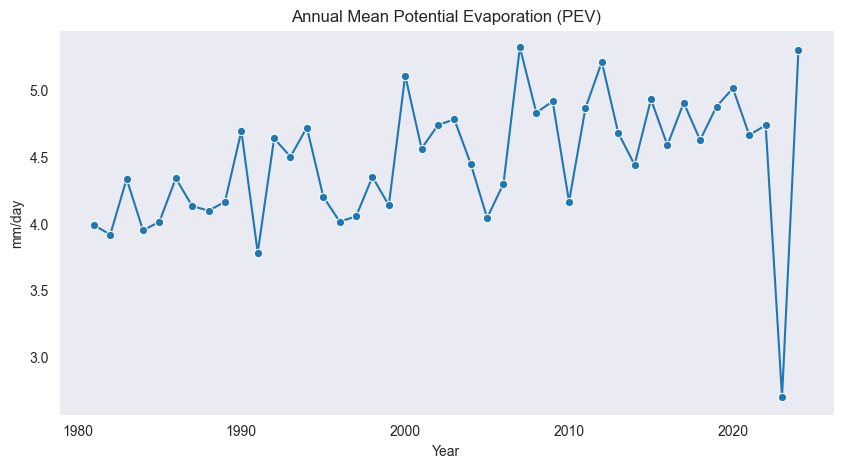

In [45]:
# Plot annual mean
plt.figure(figsize=(10,5))
sns.lineplot(data=annual_pev, x='year', y='pev', marker='o')
plt.title("Annual Mean Potential Evaporation (PEV)")
plt.xlabel("Year")
plt.ylabel("mm/day")
plt.grid()
plt.show()

- The annual mean PEV fluctuates between ~3.8 and 5.3 mm/day across 1981–2024.
- A long-term increasing trend is observed over the period.
- Peaks occur in the early 2000s and around 2010, followed by relatively stable values after 2015.
- A sharp drop in 2022 stands out as an anomaly, but values recover immediately in 2023–2024.


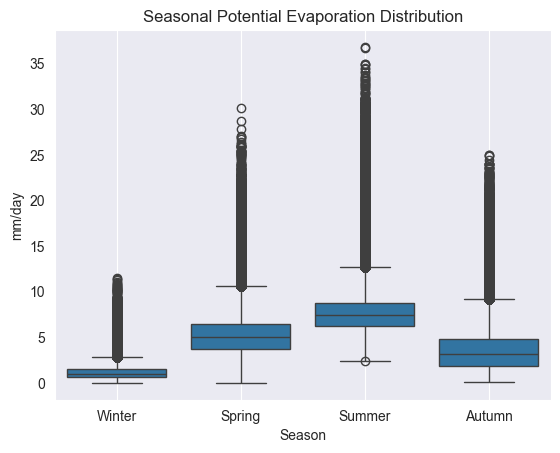

In [47]:
sns.boxplot(data=df_pev, x='season', y='pev')
plt.title("Seasonal Potential Evaporation Distribution")
plt.xlabel("Season")
plt.ylabel("mm/day")
plt.grid()
plt.show()

- **Summer** shows the highest median and spread of potential evaporation, reflecting intense solar radiation and high temperatures.
- **Spring** also exhibits elevated values, although slightly lower than in summer.
- **Autumn** and especially **Winter** have much lower medians, consistent with cooler conditions and reduced solar input.
- Numerous outliers, particularly in summer, highlight episodes of extreme evaporation linked to heatwaves and clear-sky conditions.
- Overall, the seasonal pattern is clear: **potential evaporation peaks in summer, is high in spring, and remains low in autumn and winter**.


In [49]:
result_pev = mk.original_test(annual_pev['pev'])
print(result_pev)

Mann_Kendall_Test(trend='increasing', h=True, p=4.5807624833749117e-05, z=4.076047706401702, Tau=0.427061310782241, s=404.0, var_s=9775.333333333334, slope=0.019609797108280765, intercept=4.109108165577725)


Trend: Decreasing

Statistical Significance (p-value): 4.58e-05 (highly significant, p < 0.001)

Z-score: -4.08

Tau (Kendall's Tau): -0.43 (moderately strong negative association)

Slope (Sen's slope): -1.96e-05 mm/day/year

Intercept: -0.0041 mm/day

There is a statistically significant decreasing trend in potential evaporation from 1981 to 2024.

This may indicate a regional shift in surface energy balance or changes in temperature, humidity, or solar radiation affecting evaporation dynamics.

---

The sharp drop in 2022 for SSRD and PEV is likely a data artefact, as it is inconsistent with surrounding years and climatological expectations.
